In [ ]:
import marimo as mo
mo.md("# How to use the gcPCA toolbox")

How to use the gcPCA toolbox

### Introduction

In this marimo notebook I will demonstrate how to use the gcPCA toolbox in python and explain its outputs.

For this notebook, we will work with toy data, the same used for Figure 1 on the [paper](https://doi.org/10.1371/journal.pcbi.1012747).

To run this notebook locally, you will need the following:

python packages:
```
- marimo
- numpy
- scipy
- generalized_contrastive_PCA
```
You can find a tutorial_environment.yml in the github tutorial folder to create an environment with all the required python packages. Using conda:

```
conda env create -f tutorial_environment.yml
```

### Import all the required libraries

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from generalized_contrastive_PCA import gcPCA

/home/eliezyer/.cache/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-eb299469 because there was an issue with the default path (/home/eliezyer/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Generate the toy data

In [ ]:
# toy data

# this will create datasets from condition A (data_A) and B (data_B), and return their original weights (W)
n_samples = 1000
n_features = 100
data_A, data_B, W = generate_data(n_samples,n_features)

### Fitting PCA and gcPCA

For PCA we will use the SVD function from numpy. The gcPCA is set up as a class that has to be initialized and fitted. Here I'll use gcPCA version 4.

In [ ]:
# PCA
U,S,V = np.linalg.svd(data_A,full_matrices=False)

# creating gcPCA model
gcPCA_model = gcPCA(method='v4',normalize_flag=False)

# fitting gcPCA
gcPCA_model.fit(data_A,data_B)

# gcPCA outputs
print('gcPCA_model.loadings_ shape: '+str(gcPCA_model.loadings_.shape))
print('gcPCA_model.Ra_values_ shape: '+str(gcPCA_model.Ra_values_.shape))
print('gcPCA_model.Ra_scores_ shape: '+str(gcPCA_model.Ra_scores_.shape))
print('gcPCA_model.Rb_values_ shape: '+str(gcPCA_model.Rb_values_.shape))
print('gcPCA_model.Rb_scores_ shape: '+str(gcPCA_model.Rb_scores_.shape))
print('gcPCA_model.objective_values_ shape: '+str(gcPCA_model.objective_values_.shape))

gcPCA_model.loadings_ shape: (100, 100)
gcPCA_model.Ra_values_ shape: (100,)
gcPCA_model.Ra_scores_ shape: (1000, 100)
gcPCA_model.Rb_values_ shape: (100,)
gcPCA_model.Rb_scores_ shape: (1000, 100)
gcPCA_model.objective_values_ shape: (100,)


### gcPCA outputs

PCA returns loadings (the principal components in $V$), the scores of each PC in the samples ($U$) and the variance explained by each component. We organized the output of gcPCA in the same way.

- loadings_ : The gcPCA dimensions loadings, or gcPCs. They have size n x p, where n is the number of features and p the number of gcPCs. The gcPCs are ranked based on whether they explain more variance in condition A vs condition B, with the first gcPCs explaining more variance in condition A.
- Ra_scores_ : The gcPCs' scores in condition A
- Ra_values_ : The l2-norm of gcPCs in condition A, similar to eigenvalue
- Rb_scores_ : The gcPCs' scores in condition B
- Rb_values_ : The l2-norm of gcPCs in condition B, similar to eigenvalue
- objective_values_ : The value of the objective function selected.

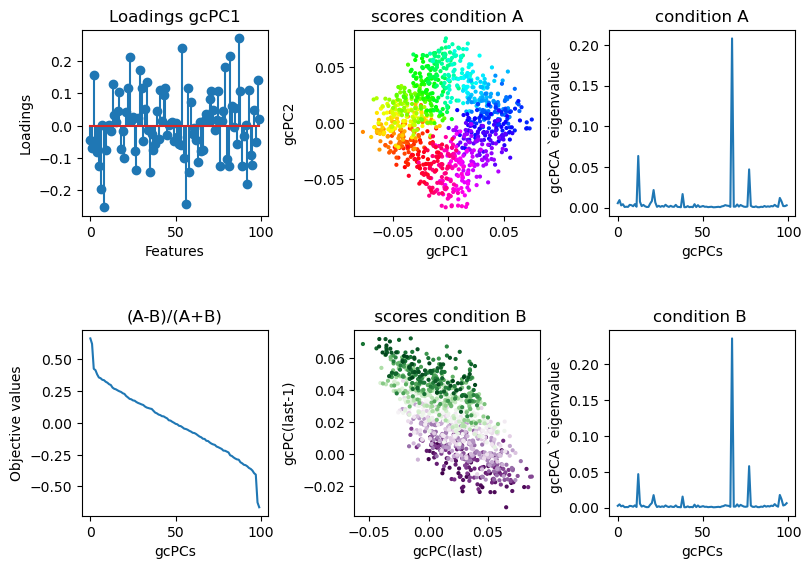

In [ ]:
# picking mapping to color the latent variables
hsv_cmap = mpl.colormaps.get_cmap('hsv')
spec_cmap = mpl.colormaps.get_cmap('PRGn')

# making the color to map to the latent variables
temp_t = np.linspace(0,1,n_samples)
hsv_col = hsv_cmap(temp_t)
spec_col = spec_cmap(temp_t)

# Create a figure with constrained layout
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)

# Helper to force square axes
def make_square(ax):
    ax.set_box_aspect(1)  # This ensures the subplot is a square (1:1 height:width)

# plot loadings
ax1 = fig.add_subplot(gs[0, 0])
ax1.stem(gcPCA_model.loadings_[:,0])
ax1.set_xlabel('Features')
ax1.set_ylabel('Loadings')
ax1.set_title('Loadings gcPC1')
make_square(ax1)

# plot condition A scores and values
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(gcPCA_model.Ra_scores_[:, 0], gcPCA_model.Ra_scores_[:, 1],c=hsv_col,s=4)
ax2.set_xlabel('gcPC1')
ax2.set_ylabel('gcPC2')
ax2.set_title('scores condition A')
make_square(ax2)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(gcPCA_model.Ra_values_)
ax3.set_xlabel('gcPCs')
ax3.set_ylabel('gcPCA `eigenvalue`')
ax3.set_title('condition A')
make_square(ax3)

# plot objective values
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(gcPCA_model.objective_values_)
ax4.set_xlabel('gcPCs')
ax4.set_ylabel('Objective values')
ax4.set_title('(A-B)/(A+B)')
make_square(ax4)

# plot condition B scores and values
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(gcPCA_model.Rb_scores_[:, -1], gcPCA_model.Rb_scores_[:, -2],c=spec_col,s=4)
ax5.set_xlabel('gcPC(last)')
ax5.set_ylabel('gcPC(last-1)')
ax5.set_title(' scores condition B')
make_square(ax5)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(gcPCA_model.Rb_values_)
ax6.set_xlabel('gcPCs')
ax6.set_ylabel('gcPCA `eigenvalue`')
ax6.set_title('condition B ')
make_square(ax6)

plt.show()

### Interpretation and comparison to PCA

From the previous plot, you can notice that the gcPCA values do not maximize the data explained within a single dataset (the last two right plots). That is because the method maximizes the data explained in condition A while minimizes in condition B, and vice versa.
This maximization of relative variance can be better observed in the lower left panel plot of objective values. Two prominent objective values of gcPCA are positive, reflecting the gcPCs related to condition A. Two prominent gcPCs are negative, reflecting condition B.

Let's compare the results of gcPCA and PCA for condition A

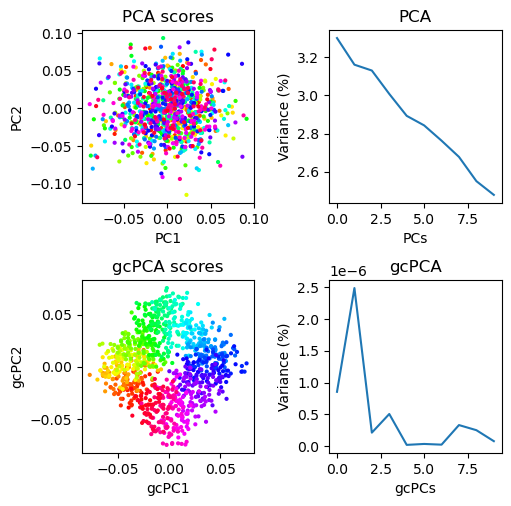

In [ ]:
# plotting the scores of PCA and gcPCA, and their variance explained
# Create a figure with constrained layout
fig2 = plt.figure(figsize=(5, 5), constrained_layout=True)
gs2 = gridspec.GridSpec(2, 2, figure=fig2)

# plot scores of PCA
ax7 = fig2.add_subplot(gs2[0, 0])
ax7.scatter(U[:,0],U[:,1],c=hsv_col,s=4)
ax7.set_xlabel('PC1')
ax7.set_ylabel('PC2')
ax7.set_title('PCA scores')
make_square(ax7)

# plot condition A scores
ax8 = fig2.add_subplot(gs2[1, 0])
ax8.scatter(gcPCA_model.Ra_scores_[:, 0], gcPCA_model.Ra_scores_[:, 1],c=hsv_col,s=4)
ax8.set_xlabel('gcPC1')
ax8.set_ylabel('gcPC2')
ax8.set_title('gcPCA scores')
make_square(ax8)

# plot scores of PCA
total_var_condA = np.var(data_A,axis=0).sum()
conditionA_var_PCA = 100*np.var(data_A@V.T,axis=0)[:10] / total_var_condA # condition A variance on the first 10 PCs
ax9 = fig2.add_subplot(gs2[0, 1])
ax9.plot(conditionA_var_PCA)
ax9.set_xlabel('PCs')
ax9.set_ylabel('Variance (%)')
ax9.set_title('PCA')
make_square(ax9)

# plot objective values
ax10 = fig2.add_subplot(gs2[1, 1])
conditionA_var_gcPCA = 100*np.var(data_A@gcPCA_model.loadings_,axis=0)[:10] / total_var_condA
ax10.plot(conditionA_var_gcPCA)
ax10.set_xlabel('gcPCs')
ax10.set_ylabel('Variance (%)')
ax10.set_title('gcPCA')
make_square(ax10)
plt.show()

The top PCs do not identify the latent factors we created in the toy data. That's because its variance is very low compared to other latent factors, the top PCs explain about 3-2% of the data's variance. The gcPCA can successfully identify the latent variables we created in the toy data, and the variance they explain is very low because they reflect dimensions of low variance. The variance of only the first 10 dimensions of each method is shown.

### Define ancillary functions

In [ ]:
# Ancillary functions for the tutorial

def generate_data(N_samples, N_features):
    from scipy.stats import zscore
    from scipy.linalg import orth
    increased_factor = 2

    # ancillary function to generate latent_factors 1 through 4
    def generate_latent_factors(N_samples):
        # factors that increase in condition A
        latent_factor1 = np.random.rand(int(N_samples), 1)
        latent_factor2 = np.random.rand(int(N_samples), 1)
        idx1 = np.logical_and(np.logical_and(latent_factor1 > 0.3, latent_factor1 < 0.7),
                              np.logical_and(latent_factor2 > 0.4, latent_factor2 < 0.6))
        latent_factor1[idx1.flatten()] = np.random.rand(sum(idx1)[0], 1) * 0.4
        latent_factor2[idx1.flatten()] = np.random.rand(sum(idx1)[0], 1) * 0.4
        latent_factor1, latent_factor2 = latent_factor1 - 0.5, latent_factor2 - 0.5
        scores_for_color = np.arctan2(latent_factor2, latent_factor1).flatten()
        Isort = np.argsort(scores_for_color)
        latent_factor1 = latent_factor1[Isort]
        latent_factor2 = latent_factor2[Isort]

        # factors increased in condition B
        temp1 = np.random.rand(int(N_samples))
        temp2 = np.random.rand(int(N_samples))
        Isort = np.argsort(temp1.flatten())
        temp1, temp2 = temp1[Isort], temp2[Isort]
        theta = np.deg2rad(45)
        latent_factor3 = temp1 * np.cos(theta) + temp2 * -np.sin(theta)
        latent_factor4 = temp1 * np.sin(theta) + temp2 * np.cos(theta)

        return latent_factor1, latent_factor2, latent_factor3, latent_factor4

    latent_factor1, latent_factor2, latent_factor3, latent_factor4 = generate_latent_factors(N_samples)

    # normalizing by the l2 norm
    latent_factor1 = latent_factor1 / np.linalg.norm(latent_factor1)
    latent_factor2 = latent_factor2 / np.linalg.norm(latent_factor2)
    latent_factor3 = latent_factor3 / np.linalg.norm(latent_factor3)
    latent_factor4 = latent_factor4 / np.linalg.norm(latent_factor4)

    # other factors
    rest_factors1 = zscore(np.random.randn(N_samples, N_features))
    rest_factors1 = rest_factors1 / np.linalg.norm(rest_factors1, axis=0)

    # generating data condition A
    # eigenvalues
    Sa = (np.linspace(0, stop=10, num=N_features)[::-1] + 10 ** -4)
    Sa[70] = increased_factor * Sa[70]  # boosting the dimensions' eigenvalue
    Sa[71] = increased_factor * Sa[71]  # boosting the dimensions' eigenvalue

    # getting orthogonal weights
    W = orth(np.random.randn(N_features, N_features)).T

    # generating samples from the low variance manifold in condition A
    samples1 = np.outer(latent_factor1, Sa[70] * W[70, :])
    samples2 = np.outer(latent_factor2, Sa[71] * W[71, :])

    # generating samples from the other factors
    auxSm = np.repeat(Sa[:70, np.newaxis], N_features, axis=1)
    newW = np.multiply(auxSm, W[:70, :])
    rest_samples1 = np.dot(rest_factors1[:, :70], newW)

    auxSm = np.repeat(Sa[72:, np.newaxis], N_features, axis=1)
    newW = np.multiply(auxSm, W[72:, :])
    rest_samples2 = np.dot(rest_factors1[:, 72:], newW)

    # adding for final data
    data_A = samples1 + samples2 + rest_samples1 + rest_samples2

    # generating data_B
    # eigenvalues
    Sb = (np.linspace(0, stop=10, num=N_features)[::-1] + 10 ** -4)
    Sb[80] = increased_factor * Sb[80]  # boosting the dimensions' eigenvalue
    Sb[81] = increased_factor * Sb[81]  # boosting the dimensions' eigenvalue

    # generating samples from the low variance manifold in condition B
    samples3 = np.outer(latent_factor3, Sb[80] * W[80, :])
    samples4 = np.outer(latent_factor4, Sb[81] * W[81, :])

    # other factors
    rest_factors1 = zscore(np.random.randn(N_samples, N_features))
    rest_factors1 = rest_factors1 / np.linalg.norm(rest_factors1, axis=0)

    # generating samples from the other factors
    auxSm = np.repeat(Sb[:80, np.newaxis], N_features, axis=1)
    newW = np.multiply(auxSm, W[:80, :])
    rest_samples1 = np.dot(rest_factors1[:, :80], newW)

    auxSm = np.repeat(Sb[82:, np.newaxis], N_features, axis=1)
    newW = np.multiply(auxSm, W[82:, :])
    rest_samples2 = np.dot(rest_factors1[:, 82:], newW)

    # adding for final data
    data_B = samples3 + samples4 + rest_samples1 + rest_samples2

    return data_A, data_B, W